# Vanilla sparse coding tutorial notebook
Basic sparse coding implemented with Euler's method, intended as an introduction to those new to the topic. It is a simplified, standalone tutorial and **does not** utilize the sparse coding library structure in `rctn/sparsecoding/`.

For technical details, see [1][Olshausen & Field 1996](http://redwood.psych.cornell.edu/papers/olshausen_field_nature_1996.pdf) and [2][Olshausen & Field 1997](http://redwood.psych.cornell.edu/papers/olshausen_field_1997.pdf).

>🚨 Before starting:
>* Make sure you've installed everything in `requirements.txt`.
>* Download whitened natural images `IMAGES.mat` (20MB) from http://www.rctn.org/bruno/sparsenet/.

If you run into any issues, please [file a bug](https://github.com/rctn/sparsecoding/issues).

In [40]:
# This extension allows us to sync changes from utils without restarting kernel.
%reload_ext autoreload
%autoreload 1
%aimport src.utils

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torchvision.utils import make_grid
from tqdm import tqdm
from src import utils

🚨 Insert your image path below.

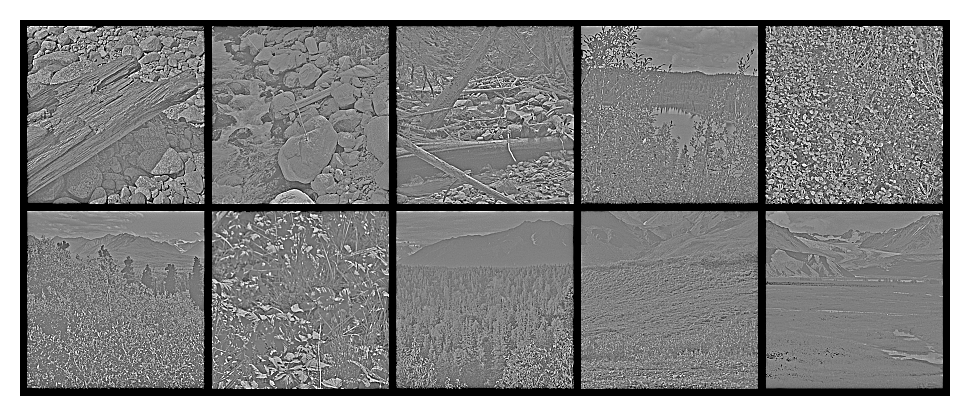

In [2]:
img_path = "IMAGES.mat"
imgs = utils.load_data(img_path)

## Problem definition
The sparse coding model is of the form 
$$ \tag{1} I(x,y) = \sum_i a_i \phi_i (x,y) + \epsilon(x,y)$$
* $I(x,y)$ denotes the pixel intensities within an image patch ($x$ and $y$ are spatial coordinates)
* $\phi_i(x, y)$ are the set of basis functions or "features" for describing the image
* $a_i$ correspond to the neural activity ($i$ denotes the index of the neuron)
* $\epsilon(x,y)$ is an additive noise term, assumed to be Gaussian

The goal is to find a dictionary of features that allow images to be described using as few non-zero $a_i$ as possible. For example, given an image patch 

![patch](demo_imgs/patch_example.png)

one sparse reconstruction might be a weighted combination of the following features

![example](demo_imgs/patch_example.png)

## Energy function
To compute $a_i$ for a given image $I(x,y)$, we minimize the energy function governing the system:
$$ \tag{2} E=\frac{1}{2}\sum_{x,y}\bigg[I(x,y) - \sum_i a_i \phi_i(x,y)\bigg]^2 + \lambda\sum_i C(a)$$
* The first term measures how well information is preserved, or how well the code describes the image, defined using mean squared error between the original image patch and the reconstruction.
* The second term assesses the sparseness of the code for a given image by assigning a cost defined by $C(a)$ depending on how activity is distributed among the coefficients. Representations where activity is spread over many coefficients should incur a higher cost than those where only few coefficients carry the load. Below we use $C(x) = |x|$, thus $C'(x) = sign(x)$.
* $\lambda$ is a positive constant that determines the importance of the second term relative to the first.
* In the code below, we refer to $\sum_i a_i \phi_i(x,y)$ as `Ihat`($\^{I}$).



In [43]:
# Sparse nonlinearity for the sparsity penalty; we use |x|, but there are other possibilities.
def C(x): return torch.abs(x)
def C_prime(x): return torch.sign(x)

# Calculate two terms of energy function.
def E_terms(I, Ihat, a, lambd):
    mse = F.mse_loss(Ihat, I).data
    sparseness = lambd * torch.sum(C(a))
    return mse, sparseness 

## Learning rule
How do we learn a set of basis functions $\phi$ that best accounts for the images? The most direct way is simple gradient descent on $E$ with respect to $\phi$
$$\tag{3} \Delta \phi_i(x,y) = \eta \langle a_i r(x,y)\rangle$$
* $r(x,y)$ = $I(x,y) - \sum_i a_i \phi_i(x,y)$ is the "residual image"
* $\eta$ is the learning rate

## Inference of sparse codes
Given our basis functions, how do we infer sparse coefficients $a_i$? The most basic method is to explicitly minimize $E$ with respect to $a_i$. This is determined from the equilibrium solution to the differential equation
$$\tag{4} \dot{a_i} = b_i - \sum_j G_{ij}a_j - \lambda C'(a)$$
<!---TODO: edit this and below code to use '97 notation. Also explain why codes are sparse using this method when there is no explicit threshold?--->
* $b_i = \sum_{x,y}\phi_i(x,y) I(x,y)$
* $G_{ij} = \sum_{x,y}\phi_i(x,y)\phi_j(x,y)$


## Defining parameters
For the first pass, we suggest using the preset parameters below to make sure everything is working. After that, we recommend playing with the parameters to see how the outputs change.

In [44]:
# Tunable parameters.
epochs = 3000
num_infer_iters = 300
batch_size = 100
lambd = 0.8
phi_lr = 1e-3
eta = 1e-3

# Init image variables.
num_bases = 64  # Size of feature dictionary.
patch_size = 8  # Each image is 8x8 pixels.
N = patch_size**2  # Number of pixels per image.

# Setting seed may be helpful for debugging.
seed = 0
torch.manual_seed(seed)
rng = np.random.default_rng(seed=seed)

# Initialize dict and visualize.
phi = torch.randn(N, num_bases)
phi = F.normalize(phi, dim=0)

Next, create patches. This will take a few minutes, but will only need to be done once (unless you increase `epochs` to be greater than `num_patches`). Note that the model only sees each patch once.

loading patches already preprocessed at patches_5000


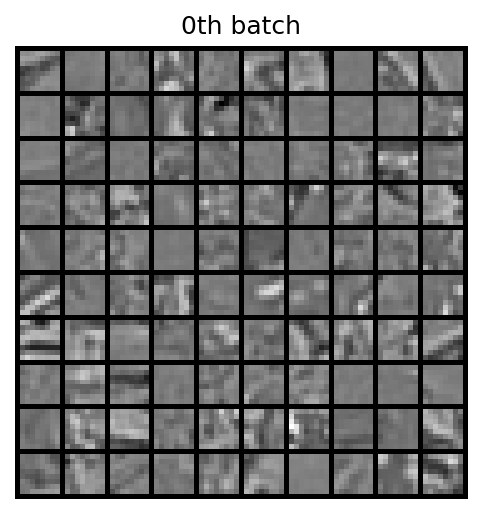

In [4]:
# Load or process patches.
num_patches = 5000  # This can be changed to a smaller number, but epochs must be <= num_patches.
patch_dir = "patches_{}".format(num_patches)
patches = utils.create_patches(imgs, num_patches, batch_size, N, patch_dir, rng)
utils.visualize_patches(patches[0, :, :], "0th batch")

## Let's run some code!
The main sparse coding algorithm consists of an outer loop that learns the dictionary features and an inner loop that infers coefficients based on the basis features.

In [46]:
# Store losses for plotting later.
mses = []
sparse_costs = []

for i in tqdm(range(epochs)):
    I = patches[i, :, :]
    a = torch.zeros(batch_size, num_bases)
    # TODO define Ihat
    Ihat = torch.mm(phi, a.T).T  # (batch_size, N)
    r = I - Ihat

    # This inner for loop uses Euler's method to learn coefficients a.
    for _ in range(num_infer_iters):
        da = eta * (torch.mm(r, phi) - (lambd * C_prime(a)))
        a += da

    # Update basis gradients.
    Ihat = torch.mm(phi, a.T).T  # (batch_size, basis_size)
    dphi = phi_lr * (torch.mm((I - Ihat).T, a))  # Equation 6, (basis_size, num_bases)
    phi += dphi

    # Normalize each basis to unit length.
    phi = F.normalize(phi, dim=0)

    # Calculate energy for plotting purposes.
    mse, sparse_cost = E_terms(I, Ihat, a, lambd)
    mses.append(mse)
    sparse_costs.append(sparse_cost)


100%|██████████| 3000/3000 [00:53<00:00, 56.11it/s]


Let's look at our learned basis functions. They should be localized, oriented, and bandpass.


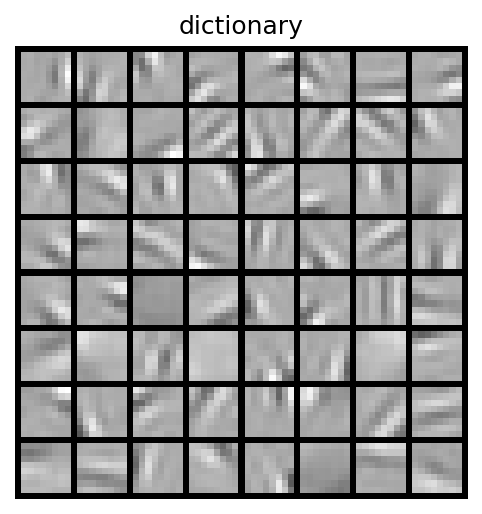

In [47]:
utils.visualize_bases(phi, "dictionary")

And here's how our reconstructions compare to the original patches, for one batch.

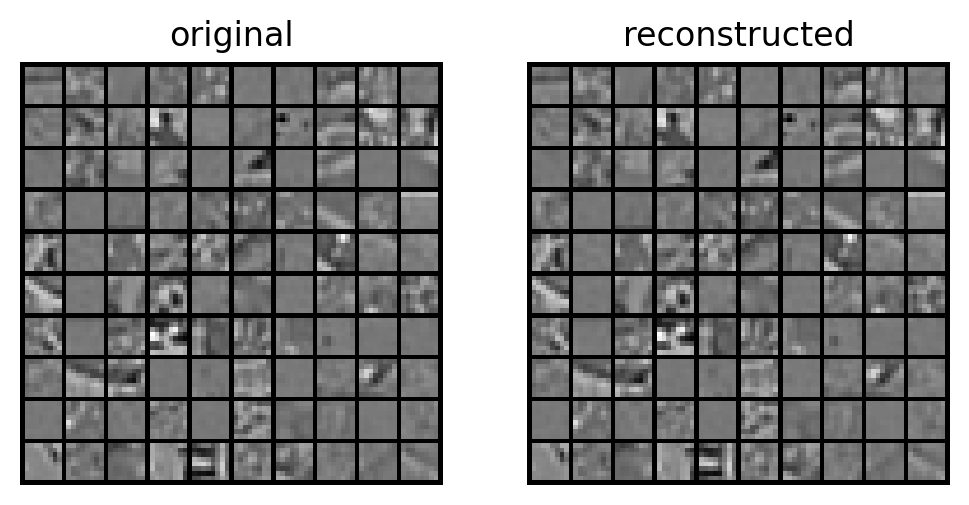

In [48]:
utils.visualize_patches_sbs(I, Ihat)

We can see how the MSE and sparsity cost change over time.

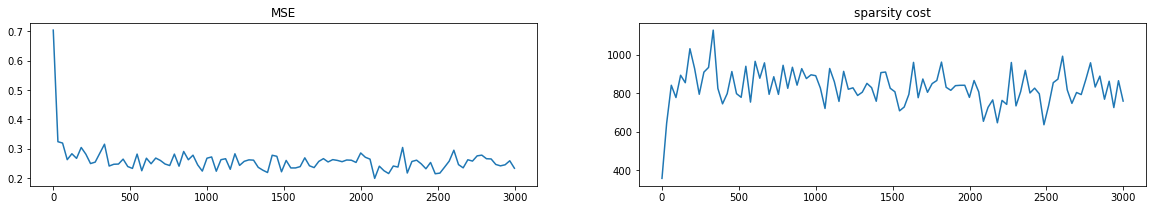

In [49]:
# Plot losses.
utils.plot_loss_sbs(mses, sparse_costs)

Let's focus on one patch. We can look at the stem plot of the coefficients and what bases are used to reconstruct the image. Each stem represents the value of one coefficient. The grid shows each $\phi_i$ weighted by $a_i$, sorted by intensity.

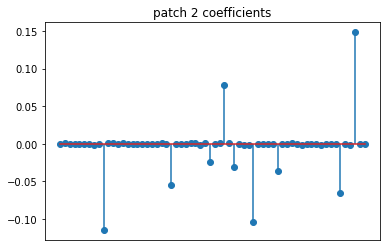

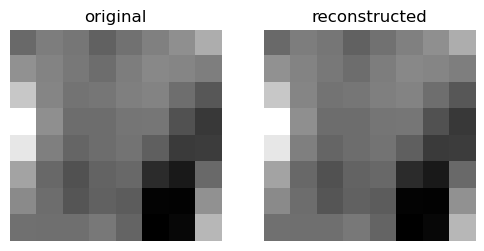

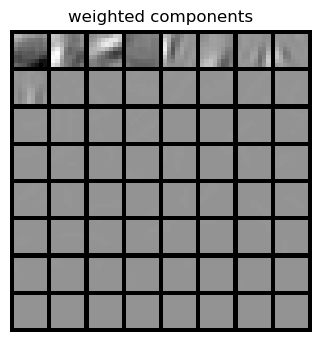

In [53]:
img_id = 2
single_patch = I[img_id, :]
single_recon = Ihat[img_id, :]
coeff = a[img_id]
utils.plot_coeffs(coeff, title="patch {} coefficients".format(img_id))
utils.display2(single_patch.reshape(patch_size, patch_size), single_recon.reshape(patch_size, patch_size), bar=False, dpi=100)
utils.show_components(phi, coeff)

single_recon = Ihat[img_id, :]
plt.imsave("patch_example.png", single_patch.reshape(8,8), cmap="gray")


Some codes are sparser than others. Let's take a look at all the inferred coefficients of this batch. Note the different y axis scales.

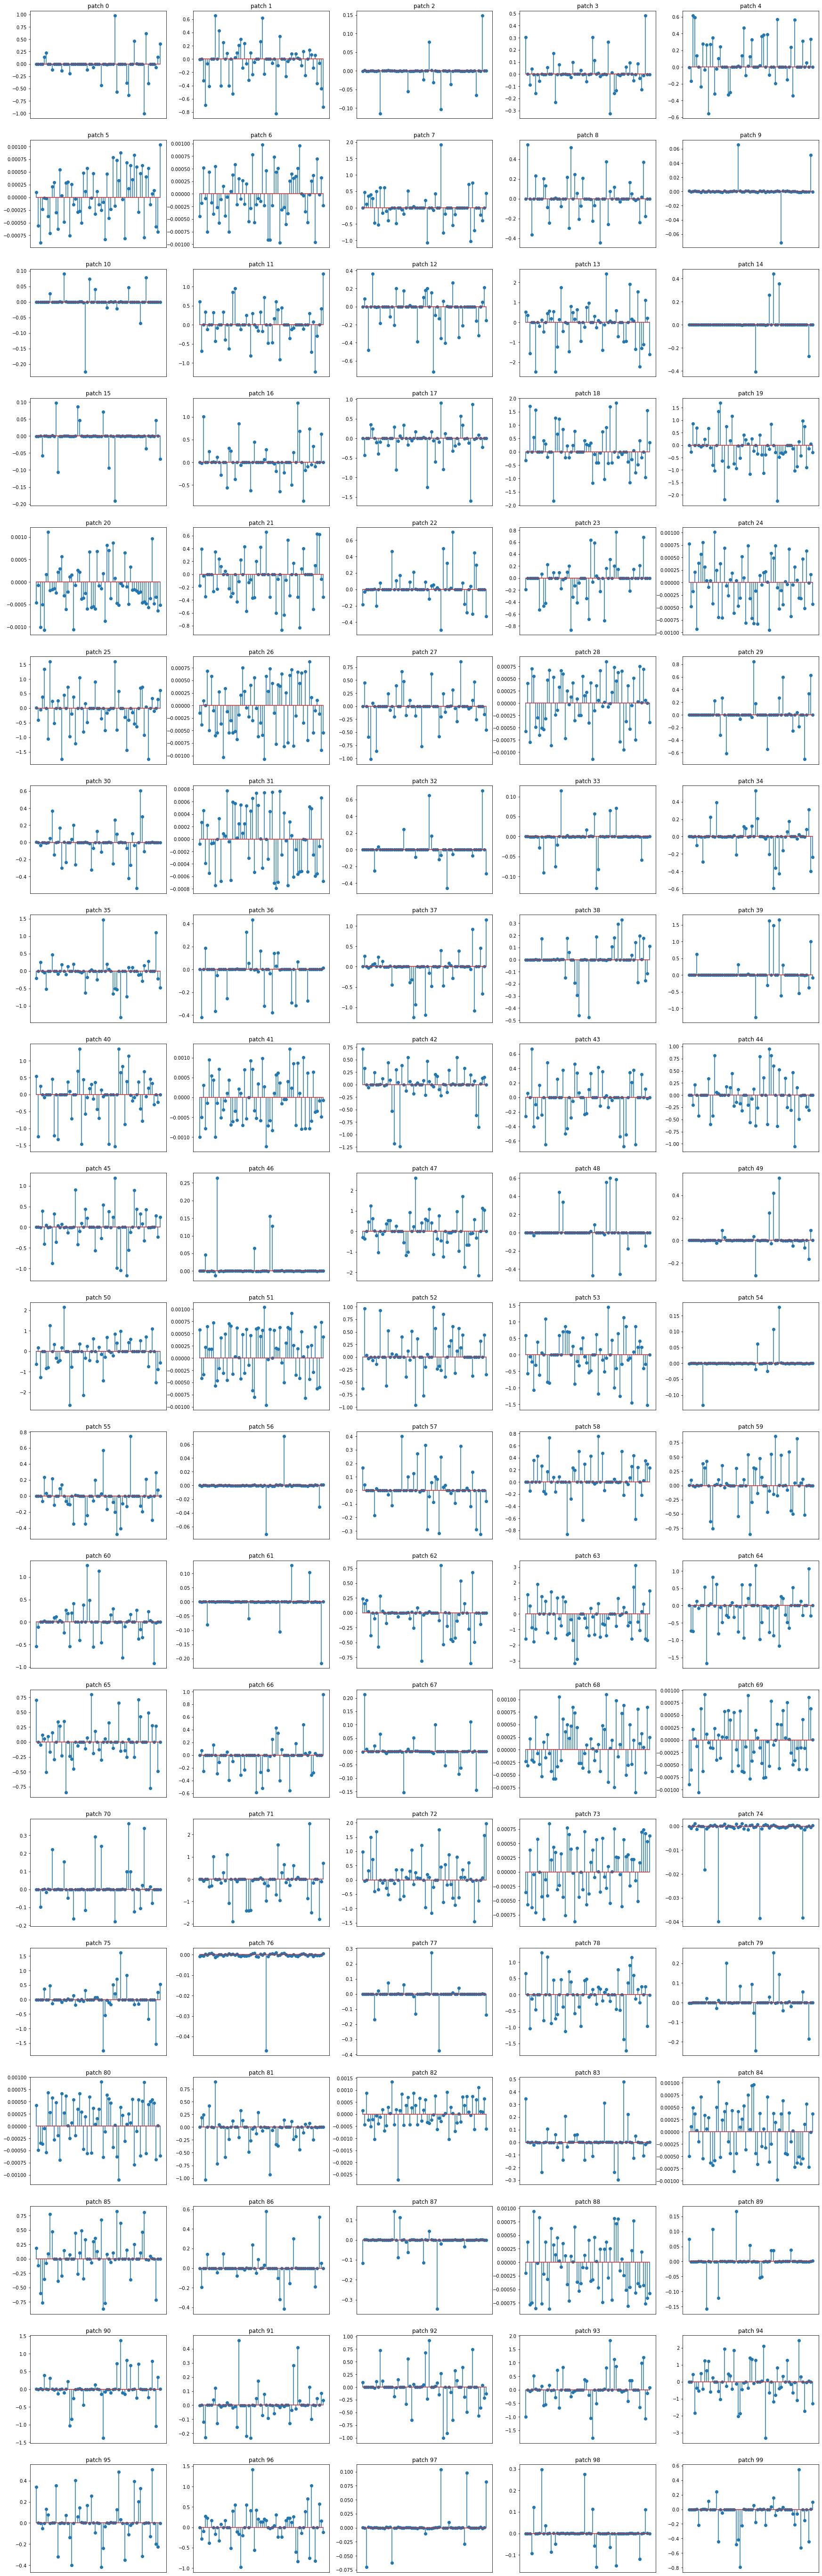

In [51]:
utils.coeff_grid(a)

This concludes the sparse coding tutorial. Feel free to play with the parameters and see how the results change. You can also check out the rest of the library. Contributions are always welcome!